In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
def explode_unique(series):
    return series.str.split(';').explode().str.strip().value_counts().index.tolist()

In [3]:
def one_hot_cat_list(cat_list,series):
    one_hot = []
    for val in series.values:
        one_hot.append([1 if cat in str(val) else 0 for cat in cat_list])
    return pd.DataFrame(one_hot,columns=cat_list)

In [4]:
df = pd.read_csv('survey_data_17_to_19.csv',low_memory=False)

is_freelance = df['Employment'].str.contains('freelance')
free_df = df[is_freelance]

In [5]:
one_df = pd.DataFrame()
with_salary = free_df['Salary']>0
for col in ['DeveloperType','LanguageWorkedWith','DatabaseWorkedWith','PlatformWorkedWith','WebFrameWorkedWith']:
    cat_list = explode_unique(free_df[with_salary][col])
    dev_one_hot = one_hot_cat_list(cat_list,free_df[with_salary][col]).add_prefix(col+': ')
    one_df = pd.concat([one_df,dev_one_hot],axis=1)
    print(one_df.shape)

(4224, 20)
(4224, 58)
(4224, 79)
(4224, 105)
(4224, 117)


In [6]:
one_df['Salary']=free_df[with_salary].reset_index(drop=True)['Salary']
one_df.head()

,DeveloperType: Back-end developer,DeveloperType: Full-stack developer,DeveloperType: Front-end developer,DeveloperType: Mobile developer,DeveloperType: Database administrator,DeveloperType: Desktop or enterprise applications developer,DeveloperType: System administrator,DeveloperType: Designer,DeveloperType: DevOps specialist,"DeveloperType: C-suite executive (CEO, CTO, etc.)",...,WebFrameWorkedWith: .NET Core,WebFrameWorkedWith: Django,WebFrameWorkedWith: Spring,WebFrameWorkedWith: Cordova,WebFrameWorkedWith: Xamarin,WebFrameWorkedWith: TensorFlow,WebFrameWorkedWith: Spark,WebFrameWorkedWith: Hadoop,WebFrameWorkedWith: Torch/PyTorch,Salary
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,78000.0
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3500.0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11500.0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,150000.0
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12.0


In [7]:
y_col = 'Salary'
Xs = one_df.drop(columns=y_col)
y = one_df[y_col]

X_train,X_test,y_train,y_test = train_test_split(Xs,y,test_size=0.3,random_state=42)

In [8]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [9]:
preds = model.predict(X_test)
r2_score(y_test,preds),mean_squared_error(y_test,preds)

(-0.000789265982635845, 7.886435331230287e+206)

In [10]:
feat_coef = pd.DataFrame(X_train.columns,columns=['Feature'])
feat_coef = feat_coef.set_index('Feature')
feat_coef['Coefficient'] = model.coef_

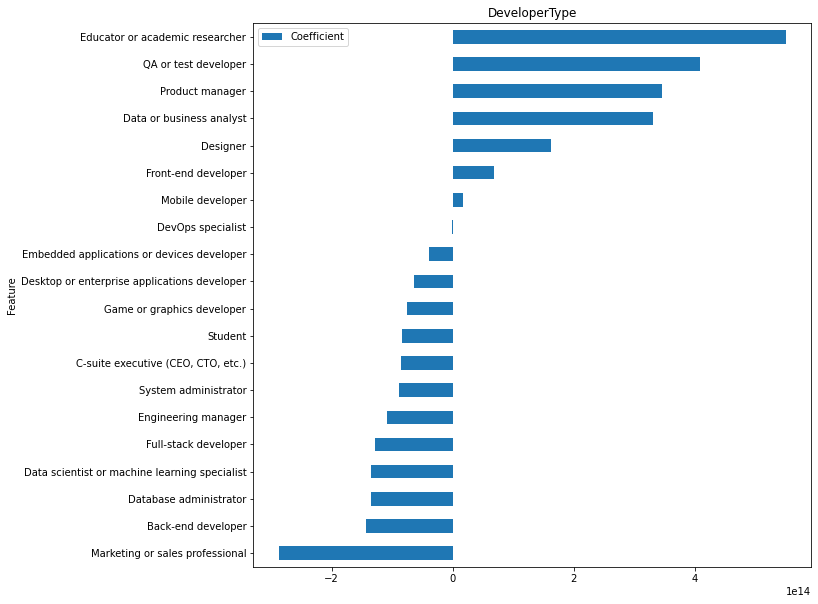

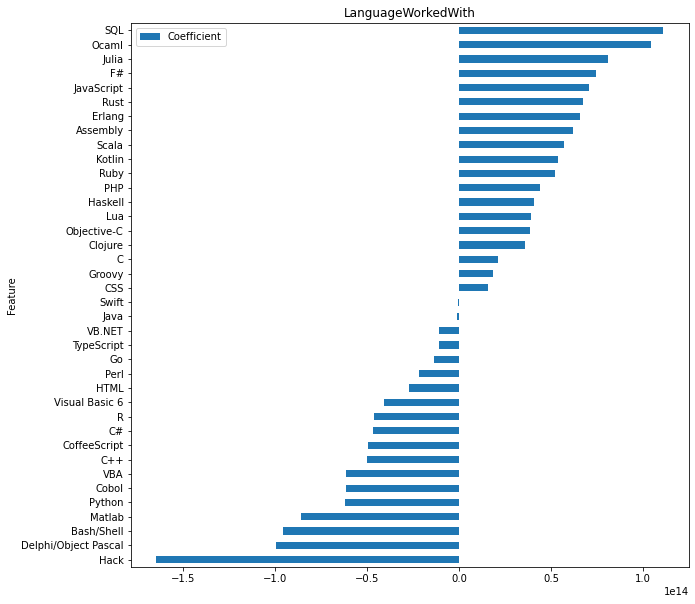

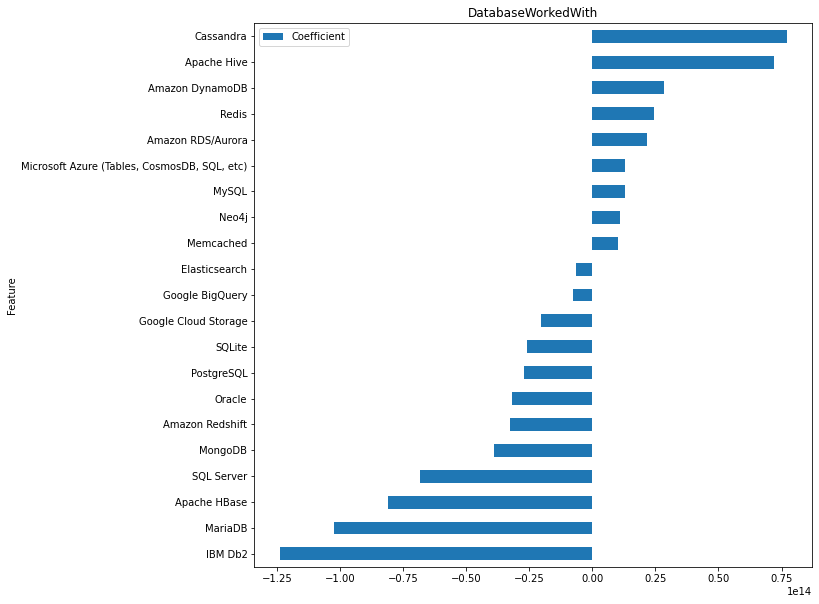

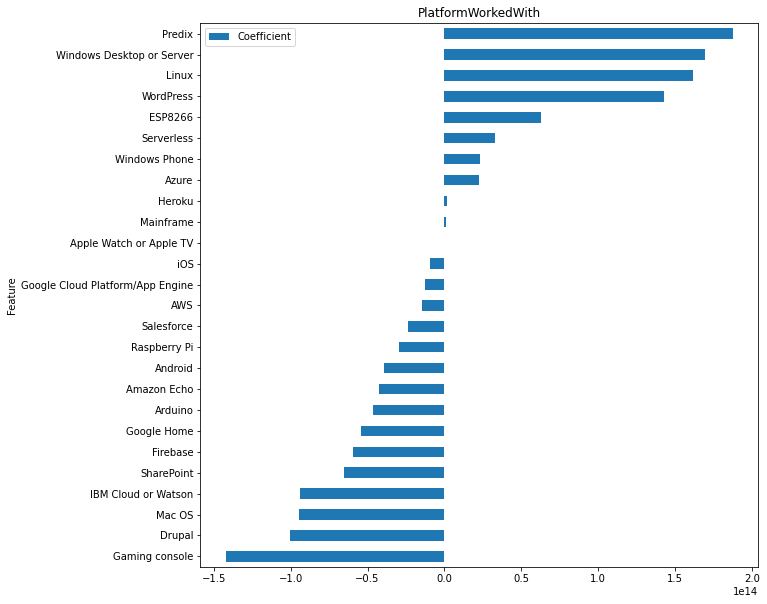

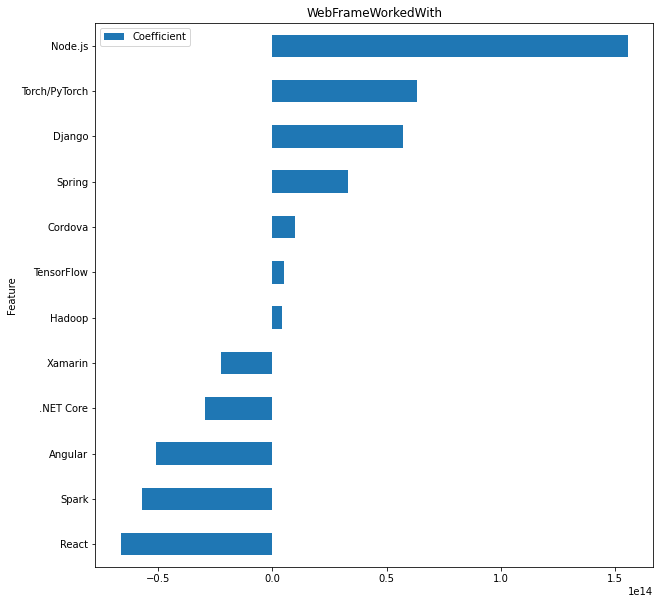

In [11]:
for col in ['DeveloperType','LanguageWorkedWith','DatabaseWorkedWith','PlatformWorkedWith','WebFrameWorkedWith']:
    contains_col = feat_coef.index.str.contains(col)
    sub_feat = feat_coef[contains_col]
    sub_feat.index = sub_feat.index.str.replace(col+': ','')
    sub_feat.sort_values('Coefficient').plot(kind='barh',figsize=(10,10))
    plt.title(col)